# Q-Learning and IFDD on Swimmer-v1
The following is the Python implementation of my Bioengineering team senior design project, which was originally written in C# on Unity3D. I naively discretize the state and action space for the sake of the replicating results from the senior design project. 
- **[Senior Design Final Report](https://drive.google.com/open?id=1coUBo_D95IpVDD-34JmWLuZ5b4kTrTGz)**
- **RL Algorithm**: [Q-Learning](https://en.wikipedia.org/wiki/Q-learning) 
- **Feature Generalization Algorithm**: [Incremental Feature Dependency Discovery](http://people.csail.mit.edu/agf/Homepage/Research/Entries/2011/12/13_Incremental_Feature_Dependency_Discovery.html)
- **Environment**: [Swimmer-v1](https://gym.openai.com/envs/Swimmer-v1/) (3-link, 2-joint snake robot)

### Summary of Environment
- We randomly run the environment to see how the observations and actions look like. The actions correspond to angle changes in degrees. The observations correspond to position and velocity. The agent is naive to its angle joints unlike in the senior design project, but can detect features such as position and velocity.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

import gym
import numpy as np
import time
import tensorflow as tf
import itertools
from itertools import chain
from itertools import combinations

# Setting up the Swimmer-v1 environment
env = gym.make('Swimmer-v1')
env.reset()
for _ in range(50):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if _ % 10 == 0:
        for i in range(len(observation)):
            observation[i] = observation[i]
        print('Example of observation:', observation)
        print('Example of action:', action)

[2017-12-31 22:56:50,004] Making new env: Swimmer-v1


Example of observation: [-0.08109433  0.082452    0.10672309 -0.07045632 -0.1433563   0.00579754
 -0.46916314  0.84124178]
Example of action: [ 0.09762701  0.43037873]
Example of observation: [-0.10998143 -0.16661395  0.80204042 -0.28888597  0.13157138 -0.37787671
 -0.43963837  2.56318907]
Example of action: [ 0.95723668  0.59831713]
Example of observation: [ 0.29600597 -1.13466024  1.74085149 -0.02795874 -0.56031318  0.62349145
 -1.0742205  -0.35476961]
Example of action: [-0.2809842  -0.12593609]
Example of observation: [ 0.44042161 -1.12662837  1.05830129  0.70285053 -0.34945979  0.66627274
  0.46954581 -3.31145821]
Example of action: [-0.68206083 -0.77924972]
Example of observation: [ 0.04464677  0.13556126 -0.72802531 -0.25083875  0.76133539 -0.47559985
  1.89179695 -3.07616744]
Example of action: [-0.36403364 -0.17147401]


### Q-Learning Linear Approximation
We approximation the Q-value function as so:  
- Qπ(s, a) = θT * φ(s, a), where θ is a transposed weight vector with shape (1, # features), and φ(s, a) is a basis function with shape (# features, actions).  
- The output is a (1, number of possible actions) vector with the Q-values for each action. 

### Incremental Feature Dependency Discovery (IFDD)
Basically, we expand the weights for linear approximation to include new features as they are "discovered". The algorithm in picture form is presented below:   
<img style="float: left;" src="http://people.csail.mit.edu/agf/Homepage/Research/Entries/2011/12/13_Incremental_Feature_Dependency_Discovery_files/shapeimage_2.png", width="300" height="300">

### Components
#### Environment 
- **State**: the (1, 8) observation taken directly from the environment. 
- **Action**: the (1, 2) action taken by the agent.
- **Possible actions**: [-0.36, 0, +0.36] degrees  

#### Features
- **Observation**: the raw information (1, 10) vector including the state and action taken. 
- **Processed observation**: the discretized information (1, 10) vector including the state and action taken. 
- **Features**: for each of the 8 state indexes, we define 11 features ranging from [-5, 5]. For each of the 2 action indexes, we define 9 features ranging from [-0.144, 0.144]. There are a total of 200 features but only 10 can be active at 1 time. We start with a powerset of only 10 initial active features, from which we add to the representation.   
- **State features**: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]. If the observation exceeds these limits, then the observation is clipped at -5 or 5. 
- **Action features**: [-0.144 -0.108 -0.072 -0.036  0. 0.036  0.072  0.108 0.144]. If the angle movement exceeds these limits, then the action is clipped at -0.144 or 0.144.   

In [2]:
# Setting up the Swimmer-v1 environment
env = gym.make('Swimmer-v1')
env.reset()
for episode in range(1):
    for timeSteps in range(50):
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if timeSteps % 10 == 0:
            for i in range(len(observation)):
                observation[i] = (observation[i])
            print('Example of action:', action)
            print('Example of observation:', observation)

[2017-12-31 22:56:50,318] Making new env: Swimmer-v1


Example of action: [ 0.35563307 -0.45998405]
Example of observation: [-0.04312105 -0.05808634  0.05101822  0.07621768  0.74405932 -0.77297774
  1.62861002 -1.61654699]
Example of action: [ 0.45050856  0.00264876]
Example of observation: [-0.21482754  0.00693234  0.52327791  0.38160174  1.85856869 -2.07291074
  3.09042959 -0.6928444 ]
Example of action: [ 0.79309319 -0.26487626]
Example of observation: [-0.62920031  0.71439942  0.16027833  0.56152743  1.34849032 -1.5243296
  2.97840601 -2.56087439]
Example of action: [ 0.39485755 -0.09291463]
Example of observation: [-0.489521    0.18295795  1.14329612 -0.19255503 -0.30513235  0.20016663
 -0.72124709  1.03130765]
Example of action: [-0.67061169  0.2429568 ]
Example of observation: [-0.73818406  0.52856708  1.00732738  0.25824717  0.25188848 -0.24220086
  0.67628593 -1.22490134]


- We write a method for generating random observations for testing our other methods.

In [3]:
def generateObservation():
    env.reset()
    for episode in range(1):
        randomEpisode = np.random.randint(100)
        for timeSteps in range(randomEpisode):
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
    testState = observation
    testAction = randomAction()
    print('Sample Observation:', testState, '\nSample Action:', testAction)
    return testState, testAction

# Output: random action
def randomAction():
    global ACTION_LEN
    randomAction = []
    for i in range(ACTION_LEN):
        randomIndex = np.random.randint(len(POSSIBLE_ACTIONS))
        randomAction.append(POSSIBLE_ACTIONS[randomIndex])
    return randomAction

# Output: random state
def randomState():
    global STATE_LEN
    randomState = []
    for i in range(STATE_LEN):
        randomIndex = np.random.randint(min(STATE_FEATURES), max(STATE_FEATURES))
        randomState.append(STATE_FEATURES[randomIndex])
    return randomState
    

# Output: randomly generated observation 
def generateRandomStateActionPair():
    state = randomState()
    action = randomAction()
    return state, action

- We set up the features for both states and actions. We also set up the feature map for processing the processed observation from the environment. These remain unchanged throughout training. We also define epsilon for the e-greedy policy. 

In [730]:
STATE_LEN = 8
ACTION_LEN = 2 
OBSERVATION_SIZE = STATE_LEN + ACTION_LEN
STATE_FEATURES = [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5]
ACTION_FEATURES = [-0.144, -0.108, -0.072, -0.036, 0., 0.036, 0.072, 0.108, 0.144]
POSSIBLE_ACTIONS = [-0.036, 0, 0.036]
FEATURE_MAP = []
for i in range(OBSERVATION_SIZE):
    if i < STATE_LEN: FEATURE_MAP.append(STATE_FEATURES)
    else: FEATURE_MAP.append(ACTION_FEATURES)
print('State Features:', STATE_FEATURES, '\nAction Features:', ACTION_FEATURES, '\nFeature Map:', FEATURE_MAP)
EPSILON = 0.01 # epsilon-greedy 
THRESHOLD = 0.9
GAMMA = 0.001 # probability of discovering new feature if exceed threshold
THETA = 0.0001 # probability of adding new feature to undiscovered set
DISCOUNT_FACTOR = 0.001 # Q-learning
LEARNING_RATE = 0.001 # weight TD update 
# ADDITIONAL_FEATURE_INDEX = len([item for sublist in FEATURE_MAP for item in sublist]) # number of current features 
print('The first new feature is added at this index:', ADDITIONAL_FEATURE_INDEX)

State Features: [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5] 
Action Features: [-0.144, -0.108, -0.072, -0.036, 0.0, 0.036, 0.072, 0.108, 0.144] 
Feature Map: [[-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-5, -4, -3, -2, -1, 0, -1, -2, -3, -4, -5], [-0.144, -0.108, -0.072, -0.036, 0.0, 0.036, 0.072, 0.108, 0.144], [-0.144, -0.108, -0.072, -0.036, 0.0, 0.036, 0.072, 0.108, 0.144]]
The first new feature is added at this index: 146


- We set up an observation processor. 

In [5]:
testState, testAction = generateObservation()

# Input: state, action
# Output: states + action observation rounded to nearest whole number (discretization)
def observationProcessor(state, action):
    global STATE_FEATURES
    processedState = []
    for i in range(len(state)): 
        processedState.append(int(state[i]))
        if state[i] > max(STATE_FEATURES): processedState[i] = max(STATE_FEATURES)
        elif state[i] < min(STATE_FEATURES): processedState[i] = min(STATE_FEATURES)
    return processedState + action
 
testObservation = observationProcessor(testState, testAction)
print('Test Processed Observation:', testObservation)

Sample Observation: [ 0.4764787  -0.98325612  0.67889959 -0.02810449  0.08006111 -0.18264584
  0.33157685 -0.60220512] 
Sample Action: [-0.036, 0]
Test Processed Observation: [0, 0, 0, 0, 0, 0, 0, 0, -0.036, 0]


- We set up a basis function. This maps each component of the processed observation to a feature, which is then mapped to an index. This is where the feature will be set to 1 for "active" with 0 elsewhere.

In [6]:
testState, testAction = generateObservation()
testObservation = observationProcessor(testState, testAction)
print('Test Processed Observation:', testObservation)

# Input: processed observation
# Output: flattened basis function  and indexes 
def basisFunction(observation):
    global OBSERVATION_SIZE, STATE_FEATURES, ACTION_FEATURES
    activeFeature = []
    for i in range(OBSERVATION_SIZE):
        index = FEATURE_MAP[i].index(observation[i])
        if i < STATE_LEN:
            basisRow = np.zeros(len(STATE_FEATURES))
            basisRow[index]  = 1
            activeFeature.append(list(basisRow))
        else:
            basisRow = np.zeros(len(ACTION_FEATURES))
            basisRow[index] = 1
            activeFeature.append(list(basisRow))
    # Flatten active feature  
    activeFeature = [item for sublist in activeFeature for item in sublist]
    # Get all indexes that are 1
    activeIndex = [i for i, item in enumerate(activeFeature) if item == 1]
    return activeFeature, activeIndex

testBasisFunction, testActiveIndex = basisFunction(testObservation)
print('Length Flattened Basis Function:', len(testBasisFunction),'\nActive Indexes Basis Function', testActiveIndex)

Sample Observation: [-0.20434763  1.12973408 -1.67807242 -0.04838913  0.3922066  -0.48260345
  0.72835113  0.07297058] 
Sample Action: [0.036, 0.036]
Test Processed Observation: [0, 0, -1, 0, 0, 0, 0, 0, 0.036, 0.036]
Length Flattened Basis Function: 106 
Active Indexes Basis Function [5, 16, 26, 38, 49, 60, 71, 82, 93, 102]


- At this point, we need to define a powerset of initial features in order to update relevances and discover new features. Then we divide the set into two sets: discovered and undiscovered. 
- **Discovered**: contains features without relevance values since they are discovered. As features are discovered, this list becomes longer. Implemented as a dictionary in order to preserve ordering.
- **Undiscovered**: contains features with relevance values since they are not discovered. This is updated during training. 
- We use the same process for calculating the basis function of observations during training, except we determine the powerset from the active indexes. 

In [7]:
testInitialState, testInitialAction = generateObservation()
testInitialObservation = observationProcessor(testInitialState, testInitialAction)
print('Test Processed Observation:', testInitialObservation)

testInitialBasisFunction, testInitialActiveIndex = basisFunction(testInitialObservation)

# Input: list of active indexes
# Output: powerset containing all subsets of active indexes as such: feature, relevance
def getPowerSet(activeIndexes):
    powerSet = []
    # Initialize relevance values  
    initialRelevance = 0
    # +1 to include the complete set as a set
    for i in range(len(activeIndexes) + 1):
        conjunctions = [[set(combo), initialRelevance] for combo in itertools.combinations(activeIndexes, i)]
        powerSet.append(conjunctions)
    # Flatten powerset into 1-dim list
    powerSet = [item for sublist in powerSet for item in sublist] 
    return powerSet

testInitialPowerSet = getPowerSet(testInitialActiveIndex)
print('Length Test Initial Powerset:', len(testInitialPowerSet))

# Input: list of initial active indexes 
# Output: powerset containing 
def getInitialDiscoveredUndiscovered(initialActiveIndexes):
    # Generate initial discovered set
    discovered = dict()
    for i in range(len(initialActiveIndexes)):
        key = str(i)
        discovered.update({key : set([initialActiveIndexes[i]])})
    # Generate initial undiscovered set
    initialPowerSet = getPowerSet(initialActiveIndexes)
    # Undiscovered set does not include the size 1 initial features or the empty set, only conjunctions. 
    undiscovered =  [item for i, item in enumerate(initialPowerSet) if len(item[0]) > 1]    
    return discovered, undiscovered

initialDiscovered, initialUndiscovered = getInitialDiscoveredUndiscovered(testInitialActiveIndex)
print('Test Initial Discovered Set:', initialDiscovered, '\nLength Test Initial Undiscovered Set:', len(initialUndiscovered))

Sample Observation: [ 0.53844451 -1.49923713  1.73527611 -0.54791667  0.30853844 -0.53121665
  0.03164423  1.64393109] 
Sample Action: [0.036, -0.036]
Test Processed Observation: [0, -1, 0, 0, 0, 0, 0, 0, 0.036, -0.036]
Length Test Initial Powerset: 1024
Test Initial Discovered Set: {'0': {5}, '1': {15}, '2': {27}, '3': {38}, '4': {49}, '5': {60}, '6': {71}, '7': {82}, '8': {93}, '9': {100}} 
Length Test Initial Undiscovered Set: 1013


- Next, we define a method for inactivating subsets of a conjunction if a conjunction is active. So if {71, 82} is discovered and active, then we set {71} and {82} in the basis function to be zero each.

In [484]:
testInitialState, testInitialAction = generateObservation()
testInitialObservation = observationProcessor(testInitialState, testInitialAction)
testInitialBasisFunction, testInitialActiveIndex = basisFunction(testInitialObservation)
testInitialPowerSet = getPowerSet(testInitialActiveIndex)
testInitialDiscovered, testInitialUndiscovered = getInitialDiscoveredUndiscovered(testInitialActiveIndex)

# Modify initialDiscovered and initialUndiscovered to include a dummy discovered feature and the full set
testRandomUndiscoveredIndex = np.random.randint(len(testInitialUndiscovered))
testRandomFeature = testInitialUndiscovered[testRandomUndiscoveredIndex]
print('Test Random Discovered Feature:', testRandomFeature)
testInitialUndiscovered.remove(testRandomFeature)
testInitialDiscovered.update({str(len(testInitialBasisFunction)): testRandomFeature[0]})
testInitialDiscovered.update({str(len(testInitialBasisFunction) + 1): set(testInitialActiveIndex)})
print('Dummy Test Discovered Set:', testInitialDiscovered)

# Modifiy basis function to include dummy discovered feature
print('Basis Function w/o discovered feature:', len(testInitialBasisFunction))
testInitialBasisFunction.append(0)
testInitialBasisFunction.append(0)
print('Basis Function w/ discovered feature:', len(testInitialBasisFunction))


# Input: set
# Output: list of subsets
def subset(mySet):
    listSubset = []
    for i in range(len(mySet) + 1):
        listSubset.append(set(itertools.combinations(mySet, i)))
    listSubset = [item for sublist in listSubset for item in sublist] 
    return listSubset


# Input: active indexes and current basis function 
# Output: temp basis function for checking if all features active 
def getBasisFromActiveIndex(activeIndex, basisFunction):
    tempBasis = np.zeros(len(basisFunction))
    for i in range(len(activeIndex)):
        tempBasis[activeIndex[i]] = 1.0
    return tempBasis

# Input: active indexes, current basis function, discovered
# Output: temp basis function with subsets = 0 and conjunction = 1
def activateConjunction(activeIndex, basisFunction, conjunctionKey):
    for i in range(len(activeIndex)):
        basisFunction[activeIndex[i]] = 0.0
    activeConjunctionIndex = int(conjunctionKey)
    basisFunction[activeConjunctionIndex] = 1.0
    return basisFunction 
 
# Input: discovered set, basis function
# Output: modified basis function 
def conjunctionBasisFunction(discoveredFeatures, basisFunction): 
    for key, feature in discoveredFeatures.items():
        if len(feature) > 1: 
            featureSubsets = subset(feature)
            for j in range(len(featureSubsets)):
                activeIndex = list(featureSubsets[j])
                tempBasis = getBasisFromActiveIndex(activeIndex, basisFunction)
                if np.array_equal(tempBasis, basisFunction):
                    basisFunction = activateConjunction(activeIndex, basisFunction, key)              
    return basisFunction
print('Before inactivating conjunction subsets:', testInitialBasisFunction)
testModifiedBasisFunction = conjunctionBasisFunction(testInitialDiscovered, testInitialBasisFunction)
print('After activating conjunction subsets:', testModifiedBasisFunction)

Sample Observation: [-0.28069538  0.01066398  1.67332149 -0.25852144 -1.20178706  1.38236383
 -2.05306044 -0.00421174] 
Sample Action: [0.036, -0.036]
Test Random Discovered Feature: [{48, 27, 100}, 0]
Dummy Test Discovered Set: {'0': {5}, '1': {16}, '2': {27}, '3': {38}, '4': {48}, '5': {60}, '6': {69}, '7': {82}, '8': {93}, '9': {100}, '106': {48, 27, 100}, '107': {100, 5, 38, 69, 16, 48, 82, 27, 60, 93}}
Basis Function w/o discovered feature: 106
Basis Function w/ discovered feature: 108
Before inactivating conjunction subsets: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

- We define a weight vector to calculate Q-values for each action, as well as the epsilon greedy policy.

In [9]:
testInitialState, testInitialAction = generateObservation()
testInitialObservation = observationProcessor(testInitialState, testInitialAction)
testInitialBasisFunction, testInitialActiveIndex = basisFunction(testInitialObservation)

# Input: Q-values
# Output: action, action index 
def epsilonGreedy(qValues):
    global EPSILON, POSSIBLE_ACTIONS
    randomNumber = np.random.uniform(0, 1)
    if randomNumber < EPSILON:
        actionIndex = np.argmax(qValues)
        return POSSIBLE_ACTIONS[actionIndex], actionIndex
    else: 
        actionIndex = np.random.randint(len(qValues))
        return POSSIBLE_ACTIONS[actionIndex], actionIndex

# Input: Q-values
# Output: action vector 
def jointEpsilonGreedy(qValues):
    jointAction = []
    jointActionIndex = []
    for i in range(ACTION_LEN):
        action, actionIndex = epsilonGreedy(qValues)
        jointAction.append(action)
        jointActionIndex.append(actionIndex)
    return jointAction, jointActionIndex
    

# Get weight vector
WEIGHT_VECTOR = []
for i in range(len(testInitialBasisFunction)):
    WEIGHT_VECTOR.append(np.random.uniform(low = -1, high = 1, size = 3))
WEIGHT_VECTOR = np.asarray(WEIGHT_VECTOR)
print('Weight vector shape:', WEIGHT_VECTOR.shape)

# Calculate Q-Value
testQVals = np.dot(testInitialBasisFunction, WEIGHT_VECTOR)
print('Test Q-values:', testQVals)

# E-greedy policy
testAction, testActionIndex = epsilonGreedy(testQVals)
print('Test Action:', testAction, 'Test Action Index:', testActionIndex)

Sample Observation: [-0.51769536  0.43663389  0.1758157   0.10255444  0.31688131 -0.104667
  1.26137511 -3.01770102] 
Sample Action: [-0.036, 0]
Weight vector shape: (106, 3)
Test Q-values: [-0.84753314  1.60989985  0.10046736]
Test Action: 0 Test Action Index: 1


- We then define a method for discovering new features and removing them from the undiscovered set. If we discover a new feature, we append another index location to the basis function and initialize another row in the weight vector. 

In [731]:
testInitialState, testInitialAction = generateObservation()
testInitialObservation = observationProcessor(testInitialState, testInitialAction)
testInitialBasisFunction, testInitialActiveIndex = basisFunction(testInitialObservation)
testInitialPowerSet = getPowerSet(testInitialActiveIndex)
testInitialDiscovered, testInitialUndiscovered = getInitialDiscoveredUndiscovered(testInitialActiveIndex)

# Modify initialDiscovered and initialUndiscovered to include a dummy discovered feature and the full set
testRandomUndiscoveredIndex1 = np.random.randint(len(testInitialUndiscovered))
testRandomUndiscoveredIndex2 = np.random.randint(len(testInitialUndiscovered))

# Modify relevance to exceed threshold for discovery
testInitialUndiscovered[testRandomUndiscoveredIndex1][1] = 4 
testInitialUndiscovered[testRandomUndiscoveredIndex2][1] = 4
testRandomFeature1 = testInitialUndiscovered[testRandomUndiscoveredIndex1]
testRandomFeature2 = testInitialUndiscovered[testRandomUndiscoveredIndex2]
print('Test Random Discovered Feature 1:', testRandomFeature1, 'Test Random Discovered Feature 2:', testRandomFeature2)

# Get random weight vector
WEIGHT_VECTOR = []
for i in range(len(testInitialBasisFunction)):
    WEIGHT_VECTOR.append(np.random.uniform(low = -1, high = 1, size = 3))

# ALGORITHM 1
# Input: td error, threshold, discovered features,  undiscovered features, additional feature index
# Output: updated discovered and undiscovered sets
def discover(tdError, threshold, discoveredFeatures, undiscoveredFeatures, additionalFeatureIndex, currentBasisFunction, weights): 
    global GAMMA, THETA 
    activeFeatures = [i for i, value in enumerate(currentBasisFunction) if value == 1.0]
    # Get powerset of active features 
    current_PowerSet = getPowerSet(activeFeatures)
    # Discover any features 
    activeOldFeatures = [i for i, feature in enumerate(undiscoveredFeatures) if feature in current_PowerSet and feature != set([])]
    for i in range(len(activeOldFeatures)):
        feature = undiscoveredFeatures[i]
        feature[1] += tdError 
        # Discover the feature if exceed the threshold and delete from undiscoveredFeatures
        # Discover feature with probability GAMMA  
        randomNumber = np.random.uniform(0, 1)
        if randomNumber < GAMMA and feature[1] > threshold and feature != set([]):
            additionalFeatureIndex += 1
            key = str(additionalFeatureIndex)
            discoveredFeatures[key] = feature[0]
            # Replace with undiscoverable relevance
            # Update sizes of basis and weights
            currentBasisFunction.append(0.0)
            weights.append(np.random.uniform(low = -1, high = 1, size = 3))
            # print('Feature:', feature, 'TDerror:', tdError, 'Feature Index:', additionalFeatureIndex)
            undiscoveredFeatures[i][1] = -1e20
                                                                              
    # Add new features  
    newUndiscoveredFeatures = [i for i, feature in enumerate(current_PowerSet) 
                               if feature[0] not in discoveredFeatures.values() 
                               and feature not in undiscoveredFeatures
                               and feature != set([])]
    for i in range(len(newUndiscoveredFeatures)): 
        feature = current_PowerSet[i]
        randomNumber = np.random.uniform(0, 1)
        if randomNumber < THETA:
            undiscoveredFeatures.append(feature)           
    return discoveredFeatures, undiscoveredFeatures, additionalFeatureIndex                                            

Sample Observation: [ 0.69812433 -1.68998017  1.52133209  0.34047918  0.14730606 -0.28277391
  1.125671   -2.16734139] 
Sample Action: [0.036, -0.036]
Test Random Discovered Feature 1: [{100, 38, 71, 80, 27, 60}, 4] Test Random Discovered Feature 2: [{38, 71, 49, 60, 93}, 4]


- We define a simple method for updating the correct weights based on the active indices of the basis function using Q-Learning, as well as a method for initializing a weight vector. 

In [266]:
testInitialState, testInitialAction = generateObservation()
testInitialObservation = observationProcessor(testInitialState, testInitialAction)
testInitialBasisFunction, testInitialActiveIndex = basisFunction(testInitialObservation)
testInitialPowerSet = getPowerSet(testInitialActiveIndex)
testInitialDiscovered, testInitialUndiscovered = getInitialDiscoveredUndiscovered(testInitialActiveIndex)

# Input: weights, activeIndex, actionIndex, reward, oldQValue, newQValues, tdError
# Output: weights 
def updateWeights(weights, activeIndex, actionIndex, reward, oldQValue, newQValues):
    for i in range(len(activeIndex)): 
        tdError = reward + DISCOUNT_FACTOR * (max(newQValues) - oldQValue)  
        weights[activeIndex[i]][actionIndex] += LEARNING_RATE * tdError
    return weights, tdError

# Input: initial basis function
# Output: random weights 
def initializeWeights(basisFunction):
    weightVector = []
    for i in range(len(basisFunction)):
        weightVector.append(np.random.uniform(low = -1, high = 1, size = 3))
    return weightVector

Sample Observation: [ 0.35443314 -1.18016702  1.03809407  0.39841719  0.15973827 -0.03424576
  1.02464274 -2.30086411] 
Sample Action: [0, 0.036]


- We write down Q-Learning only to track the TD error and emperically define a threshold. We decrement epsilon by 0.0000001 every time step.

In [736]:
start_time = time.time()
TDErrorList1 = []
RewardList1 = []
totalReward1 = 0
EPSILON = 0.01
for episode in range(1):
    # Start episode with random initial state and action   
    initialState, initialAction = generateRandomStateActionPair()
    # Process initial state and action
    initialObservation = observationProcessor(initialState, initialAction)
    # Get initial basis function and active indices 
    initialBasisFunction, initialActiveIndex = basisFunction(initialObservation)
    print('Initial Active Features:', initialActiveIndex)
    # Initialize weights 
    WEIGHT_VECTOR = initializeWeights(initialBasisFunction)
    print('Len Initial Weight Vector:', len(WEIGHT_VECTOR))
    # Divide into initial discovered and undiscovered feature sets
    DISCOVERED, UNDISCOVERED = getInitialDiscoveredUndiscovered(initialActiveIndex)
    print('Len Initial Discovered Set:', len(DISCOVERED), '\nLen Initial Undiscovered Set:', len(UNDISCOVERED))
    # Begin learning 
    oldObservation = initialObservation 
    # Multiply basis function and weights together
    oldQValues = np.dot(initialBasisFunction, WEIGHT_VECTOR)
    for timeSteps in range(2000000):
        # Choose an action using epsilon-greedy
        action, actionIndex = jointEpsilonGreedy(oldQValues)
        # Get old Q value
        oldQValue = 0.5 * (oldQValues[actionIndex[0]] + oldQValues[actionIndex[1]])
        # Take a step in the environment 
        state, reward, done, info = env.step(action)
        # Process observation
        currentObservation = observationProcessor(state, action)
        # Get basis function
        currentBasisFunction, currentActiveIndex = basisFunction(currentObservation)
        # Calculate new Q-values 
        currentQValues = np.dot(currentBasisFunction, WEIGHT_VECTOR)
        # Update weights
        WEIGHT_VECTOR, currentTDError = updateWeights(WEIGHT_VECTOR, 
                                      currentActiveIndex, 
                                      actionIndex, 
                                      reward, 
                                      oldQValue, 
                                      currentQValues)
        # Logging 
        # Outputs information every 25000 timesteps
        if timeSteps % 25000 == 0:
            current_time = time.time()
            print('Timestep:', timeSteps, 
                  'Time elapsed:', round(current_time - start_time, 2),
                  'Cumulative Reward:', round(totalReward1, 4))
        
        # Set current observation and Q-value to old
        EPSILON += 0.00000001
        totalReward1 += reward
        TDErrorList1.append(currentTDError)
        RewardList1.append(totalReward1)
        oldObservation = currentObservation
        oldQValues = currentQValues      

Initial Active Features: [1, 15, 23, 37, 46, 56, 66, 77, 93, 100]
Len Initial Weight Vector: 106
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Time elapsed: 0.02 Cumulative Reward: 0
Timestep: 25000 Time elapsed: 9.41 Cumulative Reward: -32.0747
Timestep: 50000 Time elapsed: 18.84 Cumulative Reward: -36.7496
Timestep: 75000 Time elapsed: 28.35 Cumulative Reward: -11.7686
Timestep: 100000 Time elapsed: 37.74 Cumulative Reward: -9.6377
Timestep: 125000 Time elapsed: 47.05 Cumulative Reward: 29.6534
Timestep: 150000 Time elapsed: 56.48 Cumulative Reward: 43.6914
Timestep: 175000 Time elapsed: 65.81 Cumulative Reward: 0.6885
Timestep: 200000 Time elapsed: 75.14 Cumulative Reward: 26.0445
Timestep: 225000 Time elapsed: 84.57 Cumulative Reward: 56.5968
Timestep: 250000 Time elapsed: 93.91 Cumulative Reward: 74.4311
Timestep: 275000 Time elapsed: 103.34 Cumulative Reward: 99.9184
Timestep: 300000 Time elapsed: 112.71 Cumulative Reward: 112.4356
Timestep: 32500

- TD error over 2 million time-steps

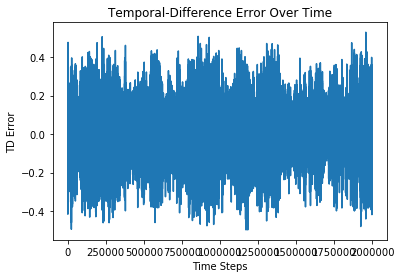

In [737]:
plt.title('Temporal-Difference Error Over Time')
plt.xlabel('Time Steps')
plt.ylabel('TD Error')
plt.plot(TDErrorList1)

- Total Reward over 2 million time-steps

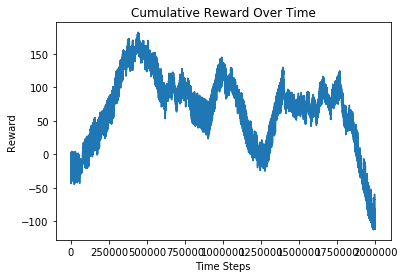

In [738]:
plt.title('Cumulative Reward Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.plot(RewardList1)

- We write down Q-Learning with IFDD. We increment epsilon by 0.00000001 every time step.

In [735]:
start_time = time.time()
TDErrorList2 = []
RewardList2 = []
DiscoverTimeList = []
totalReward2 = 0
currentTDError = 0
EPSILON = 0.01
discoverFrequency = 500
global THRESHOLD
for episode in range(1):
    # Start episode with random initial state and action   
    initialState, initialAction = generateRandomStateActionPair()
    # Process initial state and action
    initialObservation = observationProcessor(initialState, initialAction)
    # Get initial basis function and active indices 
    initialBasisFunction, initialActiveIndex = basisFunction(initialObservation)
    print('Initial Active Features:', initialActiveIndex)
    # Initialize ADDITIONAL_FEATURE_INDEX 
    ADDITIONAL_FEATURE_INDEX = len(initialBasisFunction)
    # Initialize weights 
    WEIGHT_VECTOR = initializeWeights(initialBasisFunction)
    print('Len Initial Weight Vector:', len(WEIGHT_VECTOR))
    # Divide into initial discovered and undiscovered feature sets
    DISCOVERED, UNDISCOVERED = getInitialDiscoveredUndiscovered(initialActiveIndex)
    print('Len Initial Discovered Set:', len(DISCOVERED), '\nLen Initial Undiscovered Set:', len(UNDISCOVERED))
    # Begin learning 
    oldObservation = initialObservation 
    # Multiply basis function and weights together
    oldQValues = np.dot(initialBasisFunction, WEIGHT_VECTOR)
    currentBasisFunction = []
    for timeSteps in range(2000000):
        # Choose an action using epsilon-greedy
        action, actionIndex = jointEpsilonGreedy(oldQValues)
        # Get old Q value, which is the average of both Q-values
        oldQValue = 0.5 * (oldQValues[actionIndex[0]] + oldQValues[actionIndex[1]])
        # Take a step in the environment 
        state, reward, done, info = env.step(action)
        # Process observation
        currentObservation = observationProcessor(state, action)
        # Get basis function - unmodified basis function for first time step only
        unmodifiedBasisFunction, currentActiveIndex = basisFunction(currentObservation)
        if timeSteps == 0:
            currentBasisFunction = unmodifiedBasisFunction
        else:
            currentBasisFunction = currentBasisFunction
        
        # Get modified basis function by inactivating subsets of conjunctions
        currentBasisFunction = conjunctionBasisFunction(DISCOVERED, currentBasisFunction)
        currentActiveIndex = [i for i, item in enumerate(currentBasisFunction) if item == 1]
        
       # Calculate new Q-values 
        currentQValues = np.dot(currentBasisFunction, WEIGHT_VECTOR)
        # Update weights using off-policy Q-learning
        WEIGHT_VECTOR, currentTDError = updateWeights(WEIGHT_VECTOR, 
                                      currentActiveIndex, 
                                      actionIndex, 
                                      reward, 
                                      oldQValue, 
                                      currentQValues)
        
        # Discover new features
        PREVIOUS_DISCOVERED = DISCOVERED 
        if timeSteps % startingDiscoverFrequency == 0:
            DISCOVERED, UNDISCOVERED, ADDITIONAL_FEATURE_INDEX = discover(currentTDError,
                                                                        THRESHOLD,
                                                                        DISCOVERED,
                                                                        UNDISCOVERED,
                                                                        ADDITIONAL_FEATURE_INDEX,
                                                                        currentBasisFunction,
                                                                        WEIGHT_VECTOR) 
            if len(PREVIOUS_DISCOVERED) < len(DISCOVERED):
                current_time = time.time()
                DiscoverTimeList.append(round(current_time - start_time, 2))
                discoverFrequency += discoverFrequency
                                                
        # Logging
        # Outputs information every 25000 timesteps
        if timeSteps % 25000 == 0:
            current_time = time.time()
            print('Timestep:', timeSteps, 
                  'Elapsed:', round(current_time - start_time, 2),
                  'DISCOVERED:', len(DISCOVERED),
                  'UNDISCOVERED:', len(UNDISCOVERED), 
                  'Basis:', len(currentBasisFunction),
                  'Weights:', len(WEIGHT_VECTOR),
                  'Cumul. Reward:', round(totalReward2, 4))
        
        # Set current observation and Q-value to old
        EPSILON += 0.00000001
        totalReward2 += reward
        TDErrorList2.append(currentTDError)
        RewardList2.append(totalReward2)
        oldObservation = currentObservation
        oldQValues = currentQValues   

Initial Active Features: [4, 15, 22, 36, 46, 56, 67, 81, 92, 100]
Len Initial Weight Vector: 106
Len Initial Discovered Set: 10 
Len Initial Undiscovered Set: 1013
Timestep: 0 Elapsed: 0.08 DISCOVERED: 10 UNDISCOVERED: 1013 Basis: 106 Weights: 106 Cumul. Reward: 0
Timestep: 25000 Elapsed: 12.77 DISCOVERED: 10 UNDISCOVERED: 1016 Basis: 106 Weights: 106 Cumul. Reward: 51.29
Timestep: 50000 Elapsed: 25.37 DISCOVERED: 10 UNDISCOVERED: 1023 Basis: 106 Weights: 106 Cumul. Reward: 37.5584
Timestep: 75000 Elapsed: 37.99 DISCOVERED: 10 UNDISCOVERED: 1027 Basis: 106 Weights: 106 Cumul. Reward: 38.1815
Timestep: 100000 Elapsed: 50.49 DISCOVERED: 10 UNDISCOVERED: 1028 Basis: 106 Weights: 106 Cumul. Reward: 49.4848
Timestep: 125000 Elapsed: 63.0 DISCOVERED: 10 UNDISCOVERED: 1038 Basis: 106 Weights: 106 Cumul. Reward: 66.1139
Timestep: 150000 Elapsed: 75.63 DISCOVERED: 10 UNDISCOVERED: 1044 Basis: 106 Weights: 106 Cumul. Reward: 110.9073
Timestep: 175000 Elapsed: 88.24 DISCOVERED: 10 UNDISCOVERED: 1

Timestep: 1750000 Elapsed: 15471.05 DISCOVERED: 186 UNDISCOVERED: 1314 Basis: 282 Weights: 282 Cumul. Reward: 678.9978
Timestep: 1775000 Elapsed: 16343.5 DISCOVERED: 190 UNDISCOVERED: 1320 Basis: 286 Weights: 286 Cumul. Reward: 732.1671
Timestep: 1800000 Elapsed: 17254.17 DISCOVERED: 195 UNDISCOVERED: 1324 Basis: 291 Weights: 291 Cumul. Reward: 691.2434
Timestep: 1825000 Elapsed: 18199.83 DISCOVERED: 197 UNDISCOVERED: 1331 Basis: 293 Weights: 293 Cumul. Reward: 690.2226
Timestep: 1850000 Elapsed: 19177.13 DISCOVERED: 201 UNDISCOVERED: 1335 Basis: 297 Weights: 297 Cumul. Reward: 698.6704
Timestep: 1875000 Elapsed: 20179.88 DISCOVERED: 202 UNDISCOVERED: 1338 Basis: 298 Weights: 298 Cumul. Reward: 735.6615
Timestep: 1900000 Elapsed: 21192.07 DISCOVERED: 205 UNDISCOVERED: 1340 Basis: 301 Weights: 301 Cumul. Reward: 737.2058
Timestep: 1925000 Elapsed: 22211.49 DISCOVERED: 205 UNDISCOVERED: 1342 Basis: 301 Weights: 301 Cumul. Reward: 812.0089
Timestep: 1950000 Elapsed: 23230.86 DISCOVERED: 2

- We plot our results for Q-Learning w/o IFDD vs. Q-Learning w/ IFDD for 2,000,000 timesteps below. 

- The TD error in both Q-functions are really messy. Theoretically, this should decrease over time as we learn the weights for the optimal value functions.

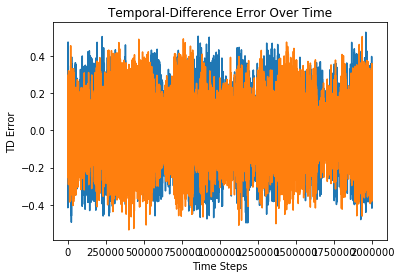

In [750]:
plt.title('Temporal-Difference Error Over Time')
plt.xlabel('Time Steps')
plt.ylabel('TD Error')
plt.plot(TDErrorList1)
plt.plot(TDErrorList2)

- The reward over time provides a clearer comparison between Q-Learning w/o and w/ iFDD. The orange line is Q-Learning w/ iFDD, which successfully increases its forward distance over time. The blue line is Q-Learning w/o iFDD, which appears to increase in distance at first but then encounter some sort of local minima that prevents it learning the weights to increase its reward. 

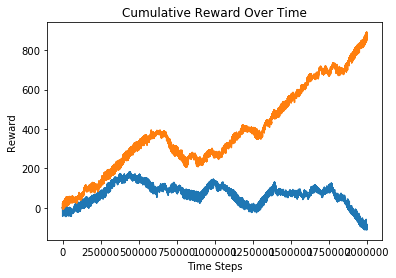

In [757]:
plt.title('Cumulative Reward Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.plot(RewardList1)
plt.plot(RewardList2)
# plt.legend((RewardList1, RewardList2), ('Q-Learning w/o iFDD', 'Q-Learning w/ iFDD'))